Steane code encoding fault tolerance
=============================== 

1. Set up two logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up fault tolerance as per scheme B, C and D from Goto H. Minimizing resource overheads for fault-tolerant preparation of encoded states of the Steane code. Sci Rep. 2016 Jan 27;6:19578. 

3. Compare this with the non fault tolerant encoding circuit and a single qubit.

3. Find out if either scheme have a tolerance.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise, 
    mean_of_list,
    calculate_standard_error,
    print_time,
    process_FT_results
    )

import matplotlib.pyplot as plt

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

NOISE = True                              #Test with noise
SHOTS = 100000                            #Number of shots to run 
SHOTS_SINGLE = 1000000                    #Number of shots to run 
MEASURE_NOISE = 0.0046                    #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366       #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0204
FACTOR_LIST = [1, 0.1, 0.01, 0.001, 0.0001]
ITERATIONS = 25
SIMULATOR = Aer.get_backend('qasm_simulator')
TITLE = 'Steane code encoding with fault tolerance'

#constants needed for correction and detection with FTc scheme
ANC_ZERO = '0000'
ANC_ONE = '0001'
QUBIT_LIST = [2,4,5] 

ANCILLA_TYPES = 2
ANCILLA_QUBITS = 3
ANCILLA_MEASUREMENT_REPEATS = 3

DATA_MEASUREMENT_REPEATS = 3
DATA_MEAS_QUBITS = 1
DATA_MEAS_START = ANCILLA_TYPES * ANCILLA_QUBITS * ANCILLA_MEASUREMENT_REPEATS
DATA_START = DATA_MEAS_START + (DATA_MEAS_QUBITS * DATA_MEASUREMENT_REPEATS)

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = ['0001111',
                       '0110011',
                       '1010101'
                      ]

In [4]:
codewords = ['0000000',
             '1010101',
             '0110011',
             '1100110',
             '0001111',
             '1011010',
             '0111100',
             '1101001'
            ]

In [5]:
def single_qubit():
    cd = QuantumRegister(1,'data')
    sd = ClassicalRegister(1,'measure_data') 
    qc = QuantumCircuit(cd, sd)
    qc.measure(cd, sd)
    if NOISE:
        result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS_SINGLE).result()
    else:
        result = execute(qc, SIMULATOR, shots = SHOTS_SINGLE).result()
    counts = result.get_counts(qc)
    return(counts)

Function module for non fault tolerant decoding circuit.

In [6]:
def encoding():
    # no fault tolerance
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False)
    qubit.set_up_logical_zero(0)
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme b from Goto's paper.  See worksheet 
"Steane_code_encoding_FTb" for circuit diagram

In [7]:
def encoding_FTb():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, 
                                   ancilla = False, fault_tolerant_b = True, 
                                   data_rounds = 3
                                  )
    qubit.set_up_logical_zero(0)
    for i in range(3):
        qubit.barrier()
        qubit.set_up_logical_zero(1)
        qubit.barrier()
        qubit.logical_gate_CX(0, 1)
        qubit.barrier()
        qubit.logical_measure_data_FT(logical_qubit = 1, measure_round = i + 1)
        qubit.barrier() 
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme c from Goto's paper.  See worksheet 
"Steane_code_encoding_FTc" for circuit diagram

In [8]:
def encoding_FTc():
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False, 
                                   fault_tolerant_c = True, data_rounds = 3,                )
    qubit.set_up_logical_zero(0)
    qubit.barrier()
    qubit.barrier()
    for i in range(3):
        qubit.encode_fault_tolerant_method_C(QUBIT_LIST)
        qubit.barrier()
        qubit.logical_measure_data_FT(0, i + 1)
        qubit.barrier()
    qubit.logical_measure_data(0)
    qubit.barrier() 
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots=SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Function module for non fault tolerant decoding circuit, based on own design.  See worksheet 
"Steane_code_encoding_FTd" for circuit diagram.

In [9]:
def encoding_FTd():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, 
                                   ancilla = False, fault_tolerant_b = True, 
                                   data_rounds = 3
                                  )
    qubit.set_up_logical_zero(0)
    for i in range(3):
        qubit.barrier()
        qubit.logical_data_reset(1)
        qubit.barrier()
        qubit.logical_gate_CX(0, 1)
        qubit.barrier()
        qubit.logical_measure_data_FT(logical_qubit = 1, measure_round = i + 1)
        qubit.barrier() 
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme c from Goto's paper, with FT ancilla.  See worksheet 
"Steane_code_encoding_FTc" for circuit diagram

In [10]:
def encoding_and_detection_FTc():
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, 
                           fault_tolerant_ancilla = True, fault_tolerant_c = True, 
                           ancilla_rounds = 3, data_rounds = 3
                          )
    qubit.set_up_logical_zero(0)
    for i in range(ANCILLA_MEASUREMENT_REPEATS):
        qubit.encode_fault_tolerant_method_C(QUBIT_LIST)
        qubit.barrier()
        qubit.logical_measure_data_FT(0, i + 1)
        qubit.barrier()
    for i in range(ANCILLA_MEASUREMENT_REPEATS):
        qubit.set_up_ancilla(0)
        qubit.logical_measure_ancilla(0, i)
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots=SHOTS).result()
    counts = result.get_counts(qubit)
    return(counts)
    #print ('The different states can be counted.  The simulated result are', counts)

Function module for non FT circuit with ancilla

In [11]:
def encoding_with_ancilla():
    # no fault tolerance
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords)
    qubit.set_up_logical_zero(0)
    qubit.set_up_ancilla(0)
    qubit.logical_measure_data(0)
    qubit.logical_measure_ancilla(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Calculation and processing of results

In [12]:
single = []
nonft = []
ftb = []
ftc = []
ftd = []
ftca = []
nonfta = []
error_single = []
error_nonft = []
error_ftb = []
error_ftc = []
error_ftd = []
error_ftca = []
error_nonfta = []

for factor in FACTOR_LIST:
    print()
    print_time()
    print(f'Processing factor {factor}')
    if NOISE:
        noise_model = get_noise(MEASURE_NOISE * factor, SINGLE_GATE_DEPOLARISING * factor, 
                                TWO_GATE_DEPOLARISING * factor, SINGLE_GATE_ERRORS, TWO_GATE_ERRORS
                               )
               
    print('Processing single qubit')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = single_qubit()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, '0')
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    single.append(mean)
    error_single.append(standard_error)
    print()
    
    print('process non FT circuit')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = encoding()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, verbose = False,)
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devations {standard_deviation:.6f}')
    nonft.append(mean)
    error_nonft.append(standard_error)
    print()
    
    print('Processing FTb')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = encoding_FTb()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, verbose = False,
                                                                            data_start = 3, data_meas_qubits = 1,
                                                                            data_meas_repeats = 3, 
                                                                            data_meas_strings = codewords
                                                                           )
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    ftb.append(mean)
    error_ftb.append(standard_error)
    print()
    
    print('Processing FTc')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = encoding_FTc()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, verbose = False,
                                                                            data_start = 3, data_meas_qubits = 1,
                                                                            data_meas_repeats = 3, 
                                                                            data_meas_strings = ['0']
                                                                           )
        
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    ftc.append(mean)
    error_ftc.append(standard_error)
    print()
    
    print('Processing FTd')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = encoding_FTd()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, verbose = False,
                                                                    data_start = 3, data_meas_qubits = 1,
                                                                    data_meas_repeats = 3, 
                                                                    data_meas_strings = codewords
                                                                   )
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    ftd.append(mean)
    error_ftd.append(standard_error)
    print()
    
    print('process FTc with FT ancilla')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = encoding_and_detection_FTc()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, 
                                                                    anc_zero = ANC_ZERO,
                                                                    anc_one = ANC_ONE,
                                                                    verbose = False,  
                                                                    data_meas_start = DATA_MEAS_START, 
                                                                    data_start = DATA_START,
                                                                    ancilla_qubits = ANCILLA_QUBITS, 
                                                                    ancilla_meas_repeats = ANCILLA_MEASUREMENT_REPEATS,
                                                                    data_meas_qubits = DATA_MEAS_QUBITS, 
                                                                    data_meas_repeats = DATA_MEASUREMENT_REPEATS
                                                                    )
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devations {standard_deviation:.6f}')
    ftca.append(mean)
    error_ftca.append(standard_error)
    print()
    
    print('process non FT circuit with ancilla')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = encoding_with_ancilla()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, verbose = False,
                                                                            data_start = 2, 
                                                                            ancilla_qubits = 1)
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devations {standard_deviation:.6f}')
    nonfta.append(mean)
    error_nonfta.append(standard_error)
    print()


Current Time = 15:37:44
Processing factor 1
Processing single qubit
The mean is 0.004612, the standard error is 0.000012
The standard devation is 0.000059

process non FT circuit
The mean is 0.176509, the standard error is 0.000199
The standard devations 0.000996

Processing FTb
The mean is 0.101010, the standard error is 0.000397
The standard devation is 0.001987

Processing FTc
The mean is 0.121483, the standard error is 0.000240
The standard devation is 0.001200

Processing FTd
The mean is 0.099654, the standard error is 0.000243
The standard devation is 0.001215

process FTc with FT ancilla
The mean is 0.123190, the standard error is 0.002688
The standard devations 0.013438

process non FT circuit with ancilla
The mean is 0.306148, the standard error is 0.000255
The standard devations 0.001273


Current Time = 16:40:12
Processing factor 0.1
Processing single qubit
The mean is 0.000461, the standard error is 0.000006
The standard devation is 0.000029

process non FT circuit
The mea

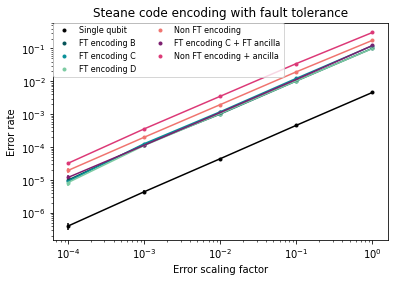

In [14]:
color1 = 'black'
color2 = '#045257'
color3 = '#089099'
color4 = '#7CCBA2'
color5 = '#F0746F'
color6 = '#7C1D6F'
color7 = '#DC3977'
plt.plot(FACTOR_LIST, single, '.', color = color1, linestyle = '', label = 'Single qubit' )
plt.plot(FACTOR_LIST, ftb, '.', color = color2, linestyle = '', label = 'FT encoding B' )
plt.plot(FACTOR_LIST, ftc, '.', color = color3, linestyle = '', label = 'FT encoding C' )
plt.plot(FACTOR_LIST, ftd, '.', color = color4, linestyle = '', label = 'FT encoding D' )
plt.plot(FACTOR_LIST, nonft, '.', color = color5, linestyle = '', label = 'Non FT encoding' )
plt.plot(FACTOR_LIST, ftca, '.', color = color6, linestyle = '', label = 'FT encoding C + FT ancilla' )
plt.plot(FACTOR_LIST, nonfta, '.', color = color7, linestyle = '', label = 'Non FT encoding + ancilla' )
plt.errorbar(FACTOR_LIST, single, yerr = error_single, color = color1 )   
plt.errorbar(FACTOR_LIST, ftb, yerr = error_ftb, color = color2 )
plt.errorbar(FACTOR_LIST, ftc, yerr = error_ftc, color = color3 )
plt.errorbar(FACTOR_LIST, ftd, yerr = error_ftd, color = color4 )
plt.errorbar(FACTOR_LIST, nonft, yerr = error_nonft, color = color5 )
plt.errorbar(FACTOR_LIST, ftca, yerr = error_ftca, color = color6 )
plt.errorbar(FACTOR_LIST, nonfta, yerr = error_nonfta, color = color7 )
plt.xlabel('Error scaling factor')
plt.ylabel('Error rate')
plt.title(TITLE)
plt.xscale("log")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 1), ncol = 2, loc = 2, borderaxespad = 0., prop={"size":8})
fname = TITLE + '.png'
plt.savefig(fname)